## Deep Learning for Speech Recognition

**Note :** You have to keep your internet toggle **ON** to successfully execute all cells of this notebook.

## Table of Contents:

- Milestone 1: Ingesting and exploring the speech command data set
- Milestone 2: Feature engineering to prepare audio data for deep learning
- Milestone 3: Neural network architectures for audio classification
- Milestone 4: Performance optimisation - tweaking the network

## Milestone 1: Ingesting and exploring the speech command data set

- download and store the data set locally or in the Google cloud
- use librosa to load and play audio
- audio as numeric data
- visualizing audio data
- splitting the data for ML

Takeaways: processing and exploratory data analysis audio data in Python

Libraries/tools: librosa, pandas, numpy, matplotlib

## Milestone 2: Feature engineering to prepare audio data for deep learning

- understand audio in the time and frequency domain
- get to know different types of spectrograms
- apply spectrograms as a feature engineering step to preprocess audio for machine learning

Takeaways: understand preprocessing of audio for ML applications

Libraries/tools: librosa, tensorflow/keras, etc.

## Milestone 3: Neural network architectures for audio classification
- understand and apply convolutional layers to spectrogram data
- experiment with different designs and parameters of the network architecture
- train the network
- inspect and validate model output (e.g. by applying the model to recordings of own voice)

Takeaways: ability to design a working neural network architecture for audio classification

Libraries/tools: tensorflow/keras

## Milestone 4: Performance optimisation - tweaking the network
- track progress in terms of classification performance
- enable training progress and diagnose lack of training progress
- discover options for tweaking the network

Takeaways: ability to do performance optimization on a neural network for audio classification

Libraries/tools: tensorflow/keras

## Milestone 1: Ingesting and exploring the speech command data set

- download and store the data set locally or in the Google cloud
- use librosa to load and play audio
- audio as numeric data
- visualizing audio data
- splitting the data for ML

Takeaways: processing and exploratory data analysis audio data in Python

Libraries/tools: librosa, pandas, numpy, matplotlib

In [1]:
import os

import numpy as np
from numpy import ndarray
import pandas as pd

import librosa

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline

In [2]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 748kB/s eta 0:00:011


In [3]:
from pyunpack import Archive
import shutil

def unpack_train_files(verbose: bool = False) -> None:
    """unzips train.7z file"""
    if not os.path.exists('/kaggle/working/train/'):
        os.makedirs('/kaggle/working/train/')
    Archive('../input/tensorflow-speech-recognition-challenge/train.7z').extractall('/kaggle/working/train/')
    if verbose:
        for dirname, _, filenames in os.walk('/kaggle/working/train/'):
            for filename in filenames:
                print(os.path.join(dirname, filename))
                
unpack_train_files()

In [4]:
# # uncomment this cell before committing
# # compress the unpacked train files into train.zip
# shutil.make_archive('train/', 'zip', 'train')

# # deleting unwanted extracted files to avoid memory overflow (maxlimit files = 500) while commiting.
# !rm -rf kaggle/working/train/*

In [5]:
# Loading the training Input folder
train_audio_path = "/kaggle/working/train/train/audio/"

# Example input file to be used here
filename = "two/b9db6e42_nohash_1.wav"

## EDA

- Get total number of classes
- Take only a subset of data to avoid long processing times
- Get number of audio files in each class - plot distribution
- Get duration of each audio file, sampling rate
- Listen to 3 audio files from each class
- Visualize spectrogram/amplitude plot/MFCC plot for 3 random audio files from each class

In [6]:
# get number of classes
import os
folders = os.listdir(train_audio_path)
print(folders)

['five', 'yes', 'bird', 'dog', 'zero', 'marvin', 'one', 'tree', '_background_noise_', 'sheila', 'six', 'four', 'eight', 'seven', 'house', 'left', 'go', 'off', 'nine', 'no', 'right', 'on', 'two', 'happy', 'three', 'bed', 'down', 'wow', 'cat', 'stop', 'up']


In [7]:
# _background_noise_ isn't a class and needs to be removed
class_names = list(filter(lambda x: not x.startswith("_"), folders))
# class_names = folders
print("Number of classes in the dataset: {}".format(len(class_names)))

Number of classes in the dataset: 30


In [8]:
# # for our demo, let's create a smaller subset of the data to reduce processing time
# # selected_classes = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
# selected_classes = ["zero", "one", "two"]
# class_names = selected_classes

In [9]:
# function to get number of items in each class
def item_count(class_name:str, path:str=train_audio_path) -> int:
    # append "/" to end of path if it isn't present
    path = path+"/" if not path.endswith("/") else path
    return len(os.listdir(path+class_name))

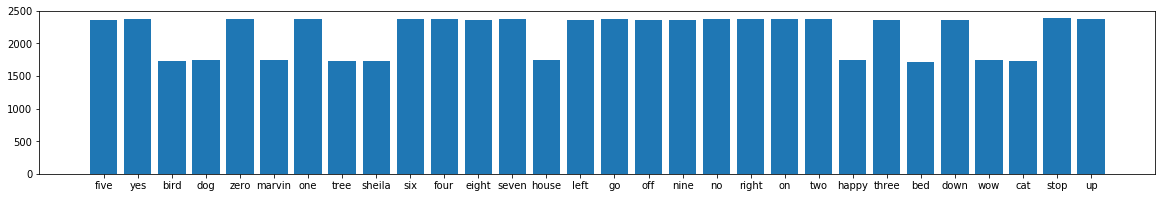

In [10]:
# get class distribution and plot bar chart
class_distribution = {cls: item_count(cls) for cls in class_names}

plt.figure(figsize=(20, 3))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.show()

Our sample dataset seems well balanced.

### Get duration of each file and it's sampling rate

In [11]:
# make a DataFrame with columns ["filename", "path", "class", "duration", "sampling rate"]
import pandas as pd
audio_df = pd.DataFrame(columns=["filename", "path", "class", "duration", "sampling rate"])

In [12]:
# helper functions for dataframe
from typing import Tuple

def get_duration(filepath: str) -> float:
    samples, sample_rate = librosa.load(filepath, sr=None)
    duration = librosa.get_duration(y=samples, sr=sample_rate)
    return duration

def get_sample_rate(filepath: str) -> int:
    samples, sample_rate = librosa.load(filepath, sr=None)
    return sample_rate

def get_class_name(filepath: str) -> str:
    return filepath.split("/")[-2]

def get_file_name(filepath: str) -> str:
    return filepath.split("/")[-1]

In [13]:
# get names of all paths
from glob import glob
audio_paths = glob("/kaggle/working/train/train/audio/*/*")
audio_df["path"] = list(filter(lambda x: get_class_name(x) in class_names, 
                               audio_paths))

In [14]:
audio_df["filename"] = audio_df["path"].progress_apply(lambda x: get_file_name(x))
audio_df["class"] = audio_df["path"].progress_apply(lambda x: get_class_name(x))

100%|██████████| 64721/64721 [00:00<00:00, 338743.49it/s]


In [15]:
audio_df["duration"] = audio_df["path"].progress_apply(lambda x: get_duration(x))

100%|██████████| 64721/64721 [00:12<00:00, 5184.43it/s]


In [16]:
audio_df["sampling rate"] = audio_df["path"].progress_apply(lambda x: get_sample_rate(x))

100%|██████████| 64721/64721 [00:12<00:00, 5097.62it/s]


In [17]:
# verify if all files have same sample rate
audio_df["sampling rate"].unique()

array([16000])

(array([1.200e+01, 2.000e+01, 1.800e+02, 1.590e+02, 3.760e+02, 6.480e+02,
        9.670e+02, 8.000e+02, 1.419e+03, 6.014e+04]),
 array([0.3715625 , 0.43440625, 0.49725   , 0.56009375, 0.6229375 ,
        0.68578125, 0.748625  , 0.81146875, 0.8743125 , 0.93715625,
        1.        ]),
 <a list of 10 Patch objects>)

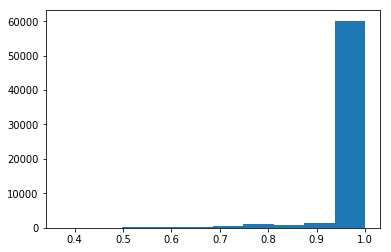

In [18]:
# check the distribution of "duration"
plt.hist(audio_df["duration"])

We see that some of the audio files have a duration less than 1.0 s. These will have to be padded with zeros in the feature engineering step.

In [19]:
audio_df.head(2)

,filename,path,class,duration,sampling rate
0,4f256313_nohash_0.wav,/kaggle/working/train/train/audio/five/4f25631...,five,1.0,16000
1,c5c60d8d_nohash_1.wav,/kaggle/working/train/train/audio/five/c5c60d8...,five,1.0,16000


In [20]:
def plot_waveform(samples: ndarray) -> None:
    plt.plot(samples)
    plt.axis("off")

In [21]:
def play_audio(filepath: str) -> None:
    ipd.display(ipd.Audio(filepath))

In [22]:
def visualize(class_name: str) -> None:
    """select 3 random files from class
    for each file, plot waveform and play audio"""
    files = audio_df[audio_df["class"]==class_name]["path"].sample(3, random_state=1)
    for path in files:
        samples, sample_rate = librosa.load(path, sr=None)
        plt.title("{}  ({})".format(class_name, path.split("/")[-1]))
        plot_waveform(samples)
        plt.show()
        play_audio(path)

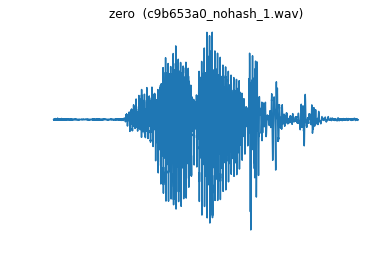

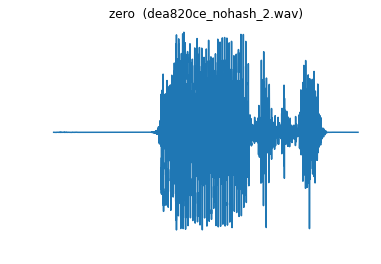

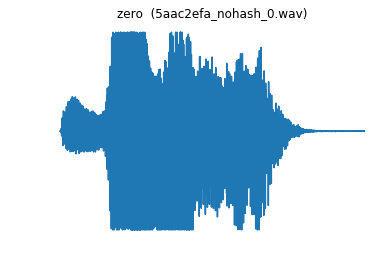

In [23]:
visualize("zero")

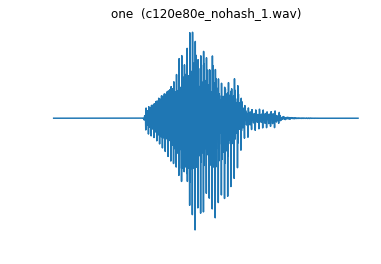

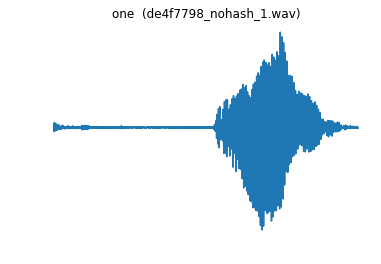

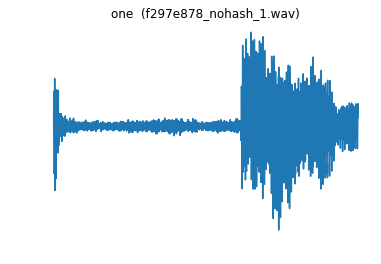

In [24]:
visualize("one")

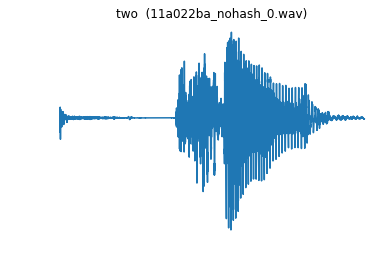

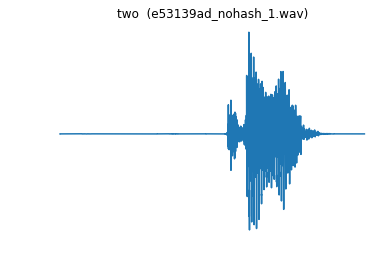

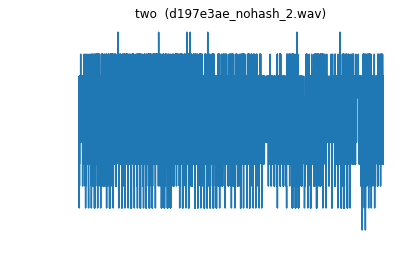

In [25]:
visualize("two")

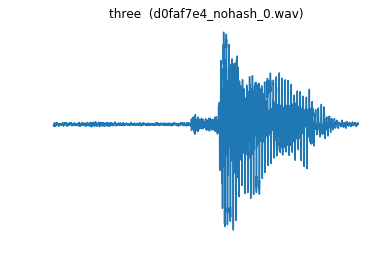

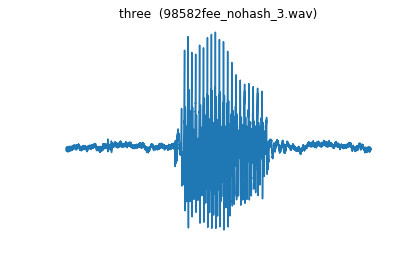

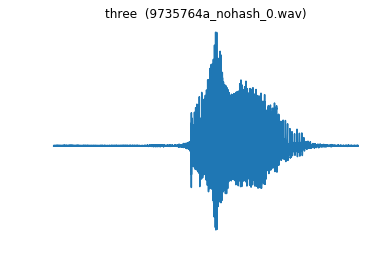

In [26]:
visualize("three")

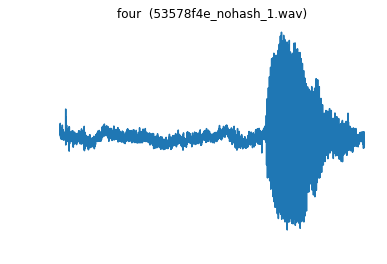

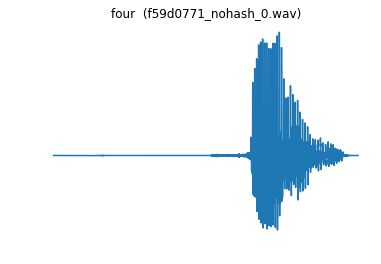

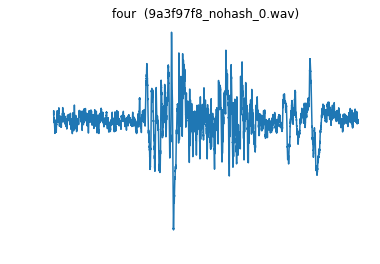

In [27]:
visualize("four")

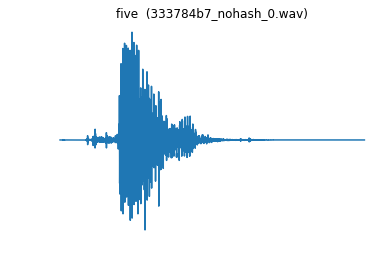

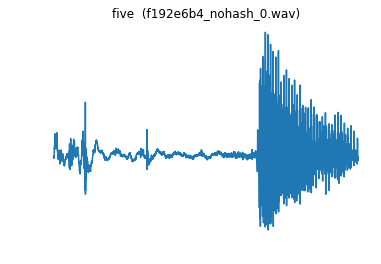

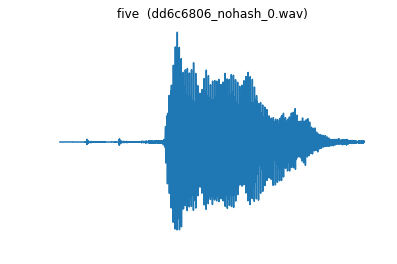

In [28]:
visualize("five")

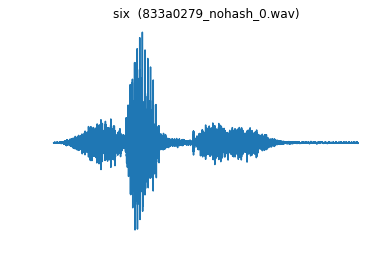

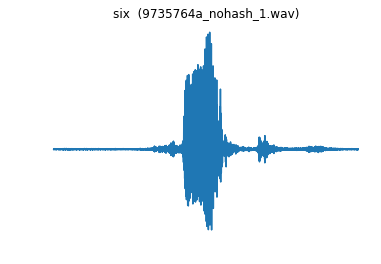

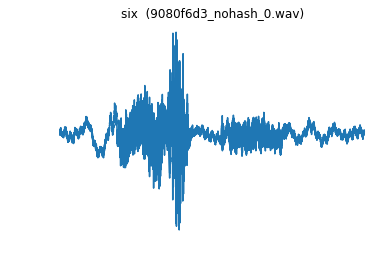

In [29]:
visualize("six")

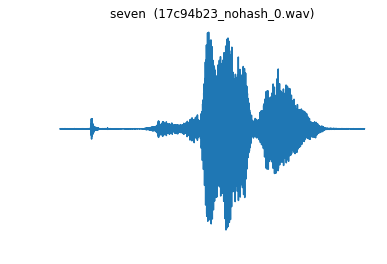

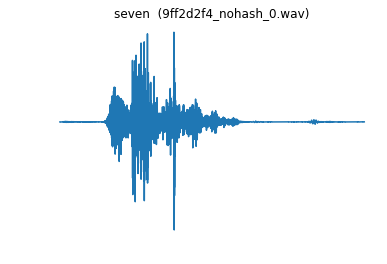

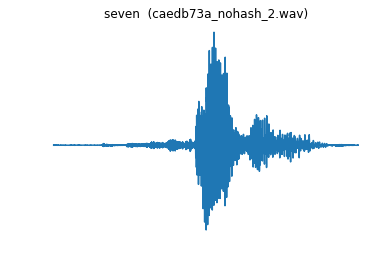

In [30]:
visualize("seven")

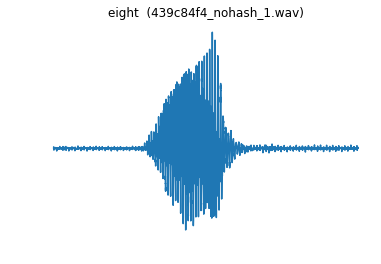

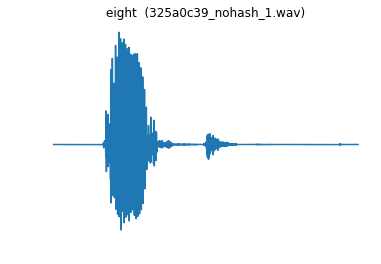

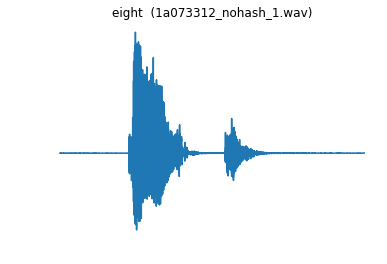

In [31]:
visualize("eight")

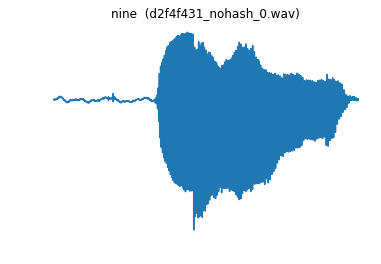

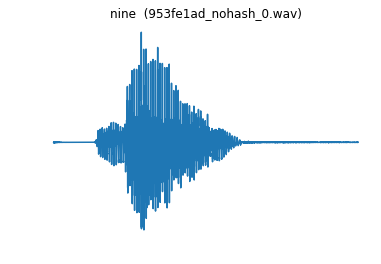

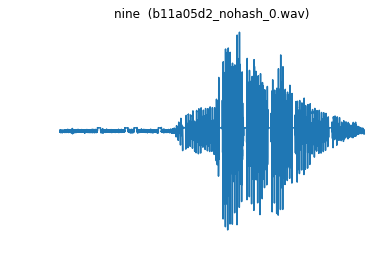

In [32]:
visualize("nine")

At lower amplitude, the signal isn't perfectly flat. This noise needs to be filtered out.

In [37]:
from typing import List

def envelope(samples: ndarray, sample_rate: int, threshold: float) -> List[bool]:
    """returns a mask that can be used to smoothen the signal"""
    mask = []
    samples = pd.Series(samples).apply(np.abs)
    sample_mean = samples.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in sample_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

16000


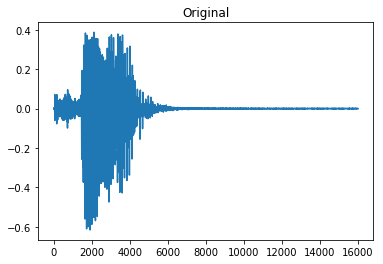

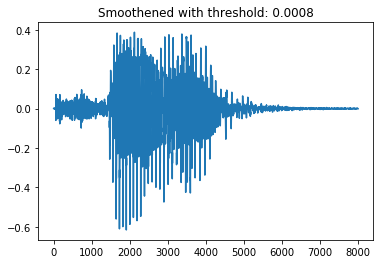

In [38]:
samples, rate = librosa.load(train_audio_path+filename, sr=None)
print(len(samples))
plt.title("Original")
plt.plot(samples)
plt.show()
threshold = 0.0008
mask = envelope(samples, rate, threshold)
samples = samples[mask]
plt.title("Smoothened with threshold: {}".format(threshold))
plt.plot(samples)

In [39]:
def pad_zeros(samples: ndarray, rate: int) -> ndarray:
    pad_length = rate-len(samples)
    return np.pad(samples, (0, pad_length), 'constant')

In [40]:
padded = pad_zeros(samples, rate)

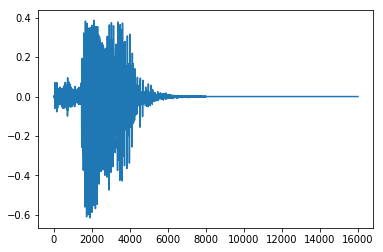

In [41]:
plt.plot(padded)

### Train-Test Split

In [42]:
# # train, val = train_test_split(audio_df[["path", "class"]], test_size=0.2)
# # train.reset_index(drop=True).to_csv("./train/train/train_subset.csv")
# # val.reset_index(drop=True).to_csv("./train/train/val_subset.csv")

## Milestone 2: Feature engineering to prepare audio data for deep learning

- understand audio in the time and frequency domain
- get to know different types of spectrograms
- apply spectrograms as a feature engineering step to preprocess audio for machine learning

### FFT(spectrum), STFT(Spectrogram), MFCCs

### FFT

Text(0, 0.5, 'Magnitude')

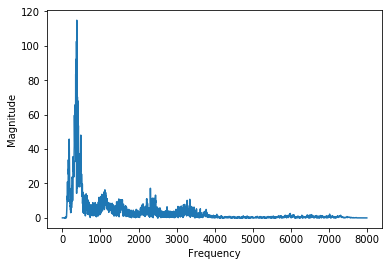

In [43]:
fft = np.fft.fft(samples)

magnitude = np.abs(fft)
frequency = np.linspace(0, rate, len(magnitude))

left_freq = frequency[:int(len(frequency)/2)]
left_mag = magnitude[:int(len(frequency)/2)]

plt.plot(left_freq, left_mag)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

### Spectrogram (STFT)

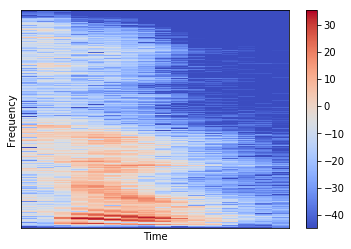

In [44]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(samples, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

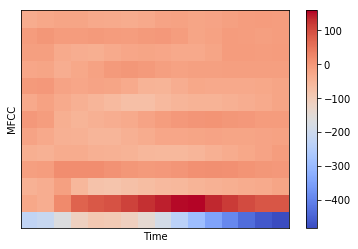

In [45]:
mfccs = librosa.feature.mfcc(samples, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(mfccs, sr=rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

### Feature Engineering - Extract Features

In [46]:
def extract_features(filepath: str, threshold: float, n_fft: int, hop_length: int, n_mfcc: int) -> ndarray:
    samples, rate = librosa.load(filepath, sr=None)
    mask = envelope(samples, rate, threshold)
    samples = samples[mask]
    samples = pad_zeros(samples, rate)
    mfccs = librosa.feature.mfcc(samples, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    return np.expand_dims(mfccs, axis=-1)

In [47]:
THRESHOLD = 0.0008
N_FFT = 2048
HOP_LENGTH = 512
N_MFCC = 13

In [63]:
# labels = audio_df["class"]

In [ ]:
# mfccs = np.load("../input/speechmfccs/mfccs.npy")
# labels = np.load("../input/speechmfccs/labels.npy")

In [120]:
mfccs, labels = audio_df["path"].progress_apply(lambda x: extract_features(x, 
                                                                           threshold=THRESHOLD, 
                                                                           n_fft=N_FFT, 
                                                                           hop_length=HOP_LENGTH, 
                                                                           n_mfcc=N_MFCC)), audio_df["class"]

100%|██████████| 64721/64721 [25:51<00:00, 41.71it/s]


In [121]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

mfccs = np.array(list(mfccs))
labels = encoder.fit_transform(labels)

n_classes = len(encoder.classes_)

In [122]:
mapping = dict(zip(range(n_classes), encoder.inverse_transform(list(range(n_classes)))))
# np.save("classes.npy", encoder.inverse_transform(labels))

### Train-test split

In [130]:
X_train, X_val, y_train, y_val = train_test_split(mfccs, labels, test_size=0.2)

In [72]:
# one-hot encode labels
from tensorflow.keras.utils import to_categorical
y_train, y_val = to_categorical(y_train), to_categorical(y_val)

## Milestone 3: Neural network architectures for audio classification

- understand and apply convolutional layers to spectrogram data
- experiment with different designs and parameters of the network architecture
- train the network
- inspect and validate model output (e.g. by applying the model to recordings of own voice)

### Model 1

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [74]:
# # define a CNN with CONV -> ReLU -> MaxPool -> FC -> ReLU -> FC
# model = Sequential()
# model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13, 32, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(n_classes, activation='softmax'))

In [75]:
# model.summary()

In [76]:
# # compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
# # train CNN
# history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), verbose=True)

In [80]:
from tensorflow.python.keras.callbacks import History

def plot_training_performance(history: History) -> None:
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.legend()
    plt.show()
    # plot accuracy
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='validation')
    plt.legend()
    plt.show()

In [81]:
# plot_training_performance(history)

Our basic model gives us pretty good results on the three classes we've used to train. However, the model slightly overfits on training data.

## Milestone 4: Performance optimisation - tweaking the network

- track progress in terms of classification performance
- enable training progress and diagnose lack of training progress
- discover options for tweaking the network

Takeaways: ability to do performance optimization on a neural network for audio classification

Libraries/tools: tensorflow/keras

Let's try to reduce overfitting using Normalization

### Model 2

In [82]:
from tensorflow.keras.layers import BatchNormalization

In [83]:
# # define a CNN with conv and 2 fc layers
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13, 32, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Dense(n_classes, activation='softmax'))

In [84]:
# model.summary()

In [85]:
# # compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
# # train CNN
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=True)

In [87]:
# plot_training_performance(history)

We can observe that overfitting has reduced when compared to the previous model.

In [88]:
# save the model
# model.save("./speech_model.h5")

In [89]:
# code for loading model
# from tensorflow.keras.models import load_model
# model = load_model("/kaggle/working/speech_model.h5")

### Model 3

In [90]:
# # add dropout along with batchnorm to reduce overfitting
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
# from tensorflow.keras.models import Sequential

# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13, 32, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(n_classes, activation='softmax'))

In [91]:
# model.summary()

In [92]:
# # compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
# # train CNN
# history = model.fit(X_train, 
#                     y_train, 
#                     epochs=100, 
#                     batch_size=16, 
#                     validation_data=(X_val, y_val), 
#                     verbose=True)

In [94]:
# plot_training_performance(history)

# Add another FC layer

### Model 4 - best accuracy

In [95]:
# # add dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13, 32, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(n_classes, activation='softmax'))

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# history = model.fit(X_train, 
#                     y_train, 
#                     epochs=60, 
#                     batch_size=16, # 32
#                     validation_data=(X_val, y_val), 
#                     verbose=True)

In [ ]:
# plot_training_performance(history)

In [ ]:
# model.save("./speech-model-2.h5")

In [97]:
from tensorflow.python.keras.callbacks import History

def plot_training_performance(history: History) -> None:
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.legend()
    plt.show()
    # plot accuracy
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='validation')
    plt.legend()
    plt.show()

In [ ]:
# mfccs = np.load("../input/speechmfccs/mfccs.npy")
# labels = np.load("../input/speechmfccs/labels.npy")

### Model 5

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13, 32, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization())
# model.add(Conv2D(128, (1, 1), activation='relu', kernel_initializer='he_uniform')) # 1x1 convolutions
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(n_classes, activation='softmax'))

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# history = model.fit(X_train, 
#                     y_train, 
#                     epochs=50, 
#                     batch_size=16, 
#                     validation_data=(X_val, y_val), 
#                     verbose=True)

In [ ]:
# plot_training_performance(history)

### Model 6

In [112]:
# add dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13, 32, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))

In [100]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=16,
                    validation_data=(X_val, y_val), 
                    verbose=True)

Train on 51776 samples, validate on 12945 samples
Epoch 1/100
51776/51776 [==============================] - 22s 426us/sample - loss: 1.8487 - accuracy: 0.4577 - val_loss: 0.8782 - val_accuracy: 0.7388
Epoch 2/100
51776/51776 [==============================] - 18s 340us/sample - loss: 1.0496 - accuracy: 0.6858 - val_loss: 0.6027 - val_accuracy: 0.8233
Epoch 3/100
51776/51776 [==============================] - 17s 330us/sample - loss: 0.8569 - accuracy: 0.7462 - val_loss: 0.4995 - val_accuracy: 0.8522
Epoch 4/100
51776/51776 [==============================] - 17s 333us/sample - loss: 0.7608 - accuracy: 0.7740 - val_loss: 0.4680 - val_accuracy: 0.8642
Epoch 5/100
51776/51776 [==============================] - 19s 363us/sample - loss: 0.7048 - accuracy: 0.7907 - val_loss: 0.4292 - val_accuracy: 0.8722
Epoch 6/100
51776/51776 [==============================] - 17s 321us/sample - loss: 0.6598 - accuracy: 0.8058 - val_loss: 0.4361 - val_accuracy: 0.8694
Epoch 7/100
51776/51776 [=============

## Test model on phone numbers

In [101]:
# our phone number is 9876543210
wav_input = "../input/phonenumber/phone_number.wav"

In [102]:
samples, rate = librosa.load(wav_input, sr=16000)

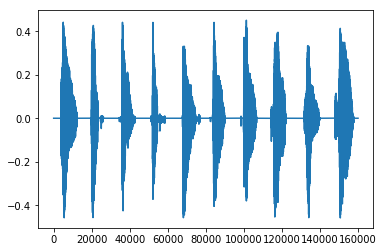

In [107]:
plt.plot(samples)
plt.show()

In [104]:
def get_mfccs(samples: ndarray, rate: int, threshold: float, n_fft: int, hop_length: int, n_mfcc: int) -> ndarray:
    mask = envelope(samples, rate, threshold)
    samples = samples[mask]
    samples = pad_zeros(samples, rate)
    mfccs = librosa.feature.mfcc(samples, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    return np.expand_dims(mfccs, axis=-1)

In [108]:
for _ in range(0, len(samples), rate):
    # split signal into 1-second chunks
    chunk = samples[_:_+rate] 
    # convert to mfccs
    mfccs = get_mfccs(chunk, rate, threshold=THRESHOLD, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    # predict
    prediction = model.predict_classes(np.array([mfccs]))
    print(mapping[prediction[0]])

nine
eight
seven
eight
five
four
three
two
one
zero


## Check Performance on Pre-trained VGG16

In [123]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow import Tensor

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [124]:
feature_extractor = VGG16(include_top=False, input_shape=(32, 32, 3))

flattened = Flatten()(feature_extractor.layers[-1].output)

fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flattened)
dropout1 = Dropout(0.2)(fc1)
bn1 = BatchNormalization()(dropout1)

fc2 = Dense(64, activation='relu', kernel_initializer='he_uniform')(bn1)
dropout2 = Dropout(0.2)(fc2)
bn2 = BatchNormalization()(dropout2)

out = Dense(n_classes, activation='softmax')(bn2)

model = Model(inputs=feature_extractor.inputs, outputs=out)

In [125]:
def reshape_mfccs(mfccs: ndarray) -> Tensor:
    """resize mfccs to size 32x32 with 3 channels"""
    mfccs = tf.convert_to_tensor(mfccs)
    mfccs = tf.image.grayscale_to_rgb(mfccs)
    return tf.image.resize(mfccs, [32, 32], method='nearest')

In [126]:
mfccs_tensors = reshape_mfccs(mfccs)

In [127]:
X_train, X_val, y_train, y_val = train_test_split(mfccs_tensors.numpy(), labels, test_size=0.2)

# one-hot encode labels
from tensorflow.keras.utils import to_categorical
y_train, y_val = to_categorical(y_train), to_categorical(y_val)

In [128]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [129]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=8, 
                    validation_data=(X_val, y_val), 
                    verbose=True)

Train on 51776 samples, validate on 12945 samples
Epoch 1/30
51776/51776 [==============================] - 103s 2ms/sample - loss: 3.1354 - accuracy: 0.0790 - val_loss: 8.9040 - val_accuracy: 0.0894
Epoch 2/30
51776/51776 [==============================] - 101s 2ms/sample - loss: 2.3786 - accuracy: 0.2208 - val_loss: 5724418.6068 - val_accuracy: 0.3917
Epoch 3/30
51776/51776 [==============================] - 99s 2ms/sample - loss: 1.8261 - accuracy: 0.3850 - val_loss: 3436156.3346 - val_accuracy: 0.5038
Epoch 4/30
51776/51776 [==============================] - 100s 2ms/sample - loss: 1.3857 - accuracy: 0.5615 - val_loss: 34865255.5406 - val_accuracy: 0.7441
Epoch 5/30
51776/51776 [==============================] - 101s 2ms/sample - loss: 1.0611 - accuracy: 0.6912 - val_loss: 1576.9603 - val_accuracy: 0.7233
Epoch 6/30
51776/51776 [==============================] - 100s 2ms/sample - loss: 0.8875 - accuracy: 0.7631 - val_loss: 523001478.7766 - val_accuracy: 0.8185
Epoch 7/30
51776/5177

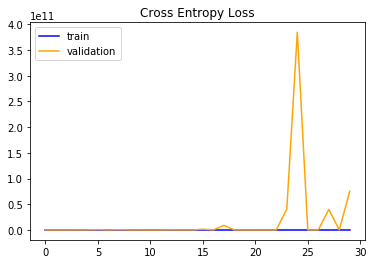

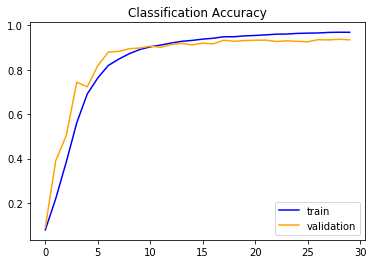

In [131]:
plot_training_performance(history)